In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection 

In [ ]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk1_train = pd.read_csv("./data/MONK/monks-1.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_train.drop('id', axis = 1, inplace = True)
df_monk1_test = pd.read_csv("./data/MONK/monks-1.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_test.drop('id', axis = 1, inplace = True)
df_monk1_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [ ]:
#get attributes and target values
X_all = df_monk1_train.iloc[:, 1:7].values
y_all = df_monk1_train.iloc[:, 0].values
X_test = df_monk1_test.iloc[:, 1:7].values
y_test = df_monk1_test.iloc[:, 0].values

# One hot encoding 

In [ ]:
def one_hot_encoder(X_all, X_test):
    enc_all = OneHotEncoder()
    enc_all.fit(X_all)
    X_all = enc_all.transform(X_all).toarray()
    
    enc_test = OneHotEncoder()
    enc_test.fit(X_test)
    X_test = enc_test.transform(X_test).toarray()
    return X_all, X_test

# Shuffle and encode data

In [ ]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(24, 17)
(100, 17)
(432, 17)
[0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]


# Define the model

In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(layers.Dense(hp.Int('units', min_value=5, max_value=20, step=3), activation='relu'))
    model.add(layers.Dense(1, activation="sigmoid"))
    hp_learning_rate = hp.Float('learning_rate', min_value=0.01, max_value=0.1, step=0.005)
    hp_momentum = hp.Choice('momentum', values=[0.8, 0.85, 0.9, 0.95])
    model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum), loss='mse', metrics=['accuracy'])
    return model


build_model(kt.HyperParameters())


In [ ]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_loss',
    max_trials=50,
    overwrite=True,
)
tuner.search_space_summary()


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
momentum (Choice)
{'default': 0.8, 'conditions': [], 'values': [0.8, 0.85, 0.9, 0.95], 'ordered': True}


In [ ]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
#tuner.search(X_train, y_train, epochs=150, batch_size=10, callbacks=[stop_early], verbose=0,  validation_data=(X_val, y_val) )
#hypermodel = MyHyperModel()
hyperparameters = tuner.get_best_hyperparameters()[0]
#model = tuner.hypermodel.build(hyperparameters)
#model = hypermodel.build(hyperparameters)

model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))


INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None
0.07499999999999998
0.9


14/14 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
loss and accuracy on training
[0.002294949721544981]
[1.0]
loss and accuracy on tes
0.004199186339974403
1.0


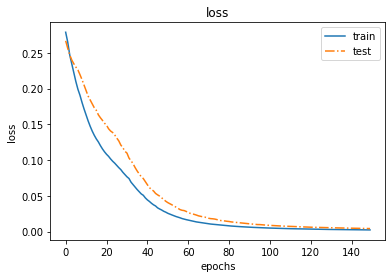

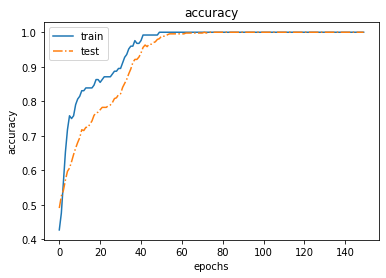

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])

plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend()
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend()
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


# Monk2

In [ ]:
#load datasets
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk2_train = pd.read_csv("./data/MONK/monks-2.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk2_train.drop('id', axis = 1, inplace = True)
df_monk2_test = pd.read_csv("./data/MONK/monks-2.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk2_test.drop('id', axis = 1, inplace = True)
df_monk2_train.head()


,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


In [ ]:
#get attribute and target values
X_all = df_monk2_train.iloc[:, 1:7].values
y_all = df_monk2_train.iloc[:, 0].values
X_test = df_monk2_test.iloc[:, 1:7].values
y_test = df_monk2_test.iloc[:, 0].values

# Shuffle data and one hot encoding

In [ ]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(33, 17)
(136, 17)
(432, 17)
[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]


In [ ]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_accuracy',
    max_trials=50,
    overwrite=True,
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
momentum (Choice)
{'default': 0.8, 'conditions': [], 'values': [0.8, 0.85, 0.9, 0.95], 'ordered': True}


# Search for best hyperparameters

In [ ]:

tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))

INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None
0.08499999999999998
0.85


# Retrain model and evaluate

14/14 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000
loss and accuracy on training
[0.0012434825766831636]
[1.0]
loss and accuracy on tes
0.001567101920954883
1.0


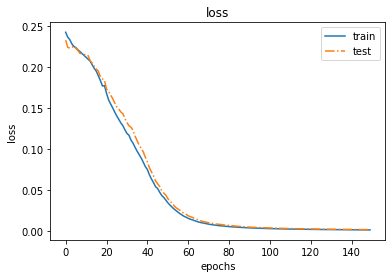

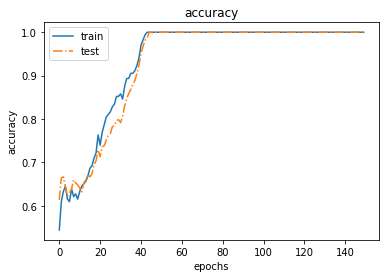

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])


plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend()
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend()
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Monk 3

In [ ]:
#load datasets
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk3_train = pd.read_csv("./data/MONK/monks-3.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk3_train.drop('id', axis = 1, inplace = True)
df_monk3_test = pd.read_csv("./data/MONK/monks-3.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk3_test.drop('id', axis = 1, inplace = True)
df_monk3_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


In [ ]:
#get attribute and target values
X_all = df_monk3_train.iloc[:, 1:7].values
y_all = df_monk3_train.iloc[:, 0].values
X_test = df_monk3_test.iloc[:, 1:7].values
y_test = df_monk3_test.iloc[:, 0].values

In [ ]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(24, 17)
(98, 17)
(432, 17)
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]


In [ ]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_accuracy',
    max_trials=100,
    overwrite=True,
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
momentum (Choice)
{'default': 0.8, 'conditions': [], 'values': [0.8, 0.85, 0.9, 0.95], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))

INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 14)                252       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15        
Total params: 267
Trainable params: 267
Non-trainable params: 0
_________________________________________________________________
None
0.09499999999999999
0.9


14/14 [==============================] - 0s 745us/step - loss: 0.1131 - accuracy: 0.9606
[0.9918032884597778]
0.9606481194496155


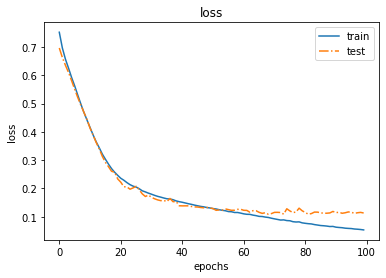

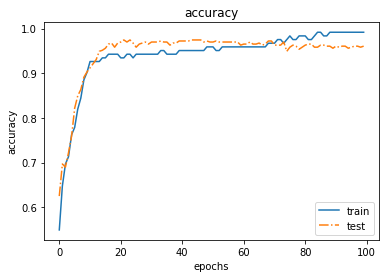

14/14 [==============================] - 0s 5ms/step - loss: 0.0544 - accuracy: 0.9352
loss and accuracy on training
[0.027624953538179398]
[0.9754098653793335]
loss and accuracy on tes
0.054386574774980545
0.9351851940155029


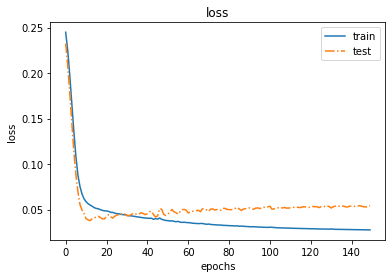

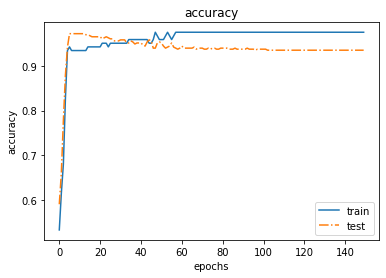

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])

plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend()
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend()
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# ML-CUP 

# Save plots in keras_results folder

In [ ]:
#define mee loss function 
def mee(true_target, predicted_target):  # assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0

    for p in range(l):  # for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p, 0] - predicted_target[p, 0])  # difference between the x value of the true and predicted target
        y_diff = np.square(
            true_target[p, 1] - predicted_target[p, 1])  # difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l

    return res

In [ ]:
#load training dataset
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'y1', 'y2']
df_ml_cup_train = pd.read_csv("./data/ML-CUP21-TR.csv", sep = ",", skipinitialspace=True, names = colnames)
df_ml_cup_train.drop(df_ml_cup_train.index[0:7], axis=0, inplace=True)
df_ml_cup_train.head()

,id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,y1,y2
7,1,0.248433,-1.801874,-1.116485,1.255230,-1.021899,-1.425146,1.029583,1.261154,-0.185208,-0.618970,7.187592,-8.768943
8,2,0.612246,0.369337,1.119434,-0.689106,0.451776,1.308115,-0.518925,0.129025,-0.558788,1.588863,0.170888,-25.895562
9,3,-0.974871,0.275613,1.106435,-0.867804,0.230839,1.870421,-0.794584,-1.712529,-0.935208,0.109706,4.167006,-29.062891
10,4,-1.493339,1.992164,0.609691,-1.001476,1.268201,0.516364,-0.984814,-1.169440,-0.765422,-0.487069,7.259387,-31.529549
11,5,-0.432028,1.592409,0.853561,-1.365528,1.310392,0.954528,-0.946305,-1.269243,-2.031158,-0.227847,5.941430,-30.540759


In [ ]:
#check for mull values 
pd.isnull(df_ml_cup_train).sum()

id     0
a1     0
a2     0
a3     0
a4     0
a5     0
a6     0
a7     0
a8     0
a9     0
a10    0
y1     0
y2     0
dtype: int64

In [ ]:
df_ml_cup_train.describe(include='all')

,id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,y1,y2
count,1477,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
unique,1477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.255579,0.002654,0.133184,0.034346,-0.073823,0.130990,0.030048,0.099646,0.130991,0.210294,2.795525,-20.028458
std,NaN,0.956072,0.939628,1.052660,0.986982,0.830759,1.030170,0.969467,0.984523,0.999224,0.997632,2.985242,7.339448
min,NaN,-2.526427,-1.918939,-2.420890,-1.946351,-1.897417,-2.040401,-1.919660,-2.095531,-2.242666,-2.847029,-2.100573,-31.773589
25%,NaN,-0.402794,-0.861932,-0.766079,-0.908341,-0.802577,-0.823261,-0.916722,-0.804613,-0.804494,-0.490529,0.041258,-26.885766
50%,NaN,0.198597,0.058046,0.193591,0.140195,-0.022032,0.195010,0.130275,0.282215,0.326109,0.003434,2.739887,-19.944627
75%,NaN,0.880185,0.755629,1.064669,0.878915,0.605930,1.035666,0.855680,0.924605,0.891953,1.046291,5.415537,-13.588640


In [ ]:
X_all = df_ml_cup_train.iloc[:, 1:11].values
y_all = df_ml_cup_train.iloc[:, 11:13].values

# Visualize target data

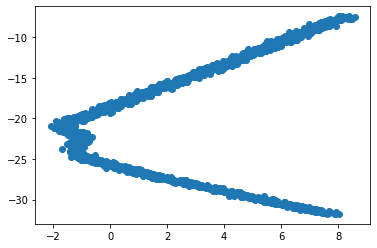

In [ ]:
plt.scatter(y_all[:,0], y_all[:,1])
plt.show()

In [ ]:
#shuffle and split data 
from sklearn.utils import shuffle 
X_all, y_all = shuffle(X_all, y_all)
train_size = int(0.75 * len(X_all))
X_train = X_all[:train_size]
y_train = y_all[:train_size]
print(X_train.shape, y_train.shape)
X_test = X_all[train_size:]
y_test = y_all[train_size:]
print(X_test.shape, y_val.shape)

(1107, 10) (1107, 2)
(370, 10) (24,)


In [ ]:
def create_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 1, 3)):
        if i == 1:
            model.add(layers.Dense(units=hp.Int('units', 10, 40, step=2), activation='relu', input_shape=(10,), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
            continue

        model.add(layers.Dense(units=hp.Int(f"units_{i}", min_value=10, max_value=40, step=2), activation='relu'))
    
    model.add(layers.Dense(2))
    hp_learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.01, step=0.00002)
    hp_momentum = hp.Choice('momentum', values=[0.0, 0.1, 0.25, 0.5, 0.75, 0.8, 0.85])
    model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum, decay=hp_learning_rate/100), loss='mse', metrics=['mae'])
    return model 

# Create a custom tuner that supports K-fold

In [ ]:
class CVTuner(kt.engine.tuner.Tuner):
    def run_trial(self, trial, X, y, batch_size, epochs):
        cv = model_selection.KFold(10)
        val_losses = []
        for train_indices, test_indices in cv.split(X):
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
            val_losses.append(model.evaluate(X_test, y_test))
        
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
        try:
            self.save_model(trial.trial_id, model)
        except:
            pass

In [ ]:
tuner = CVTuner(

    oracle=kt.oracles.RandomSearch(
        objective='val_loss',
        max_trials=20,
    ),
    hypermodel=create_model,
    overwrite=True,
    project_name='keras_results',
)

tuner.search_space_summary()

TypeError: mee() missing 2 required positional arguments: 'true_target' and 'predicted_target'

In [ ]:
tuner.search(X_train, y_train, batch_size=32, epochs=100)
hyperparameters = tuner.get_best_hyperparameters(num_trials=5)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
layers            |3                 |?                 
units_0           |16                |?                 
learning_rate     |0.00163           |?                 
momentum          |0.5               |?                 



TypeError: in user code:

    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-137-f962bd617275>:6 mee  *
        for p in range(l):  # for p-th pattern in l (number of samples)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/autograph/operators/py_builtins.py:365 range_  **
        return _py_range(start_or_stop, stop, step)
    /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/autograph/operators/py_builtins.py:390 _py_range
        return range(start_or_stop)

    TypeError: 'NoneType' object cannot be interpreted as an integer


# Ensemble by prediction average

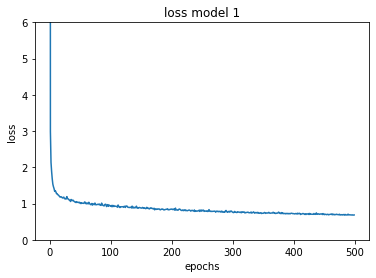

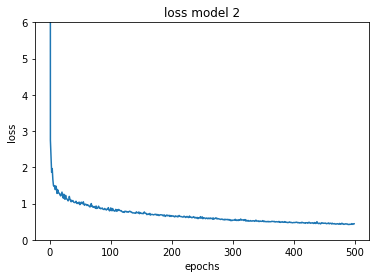

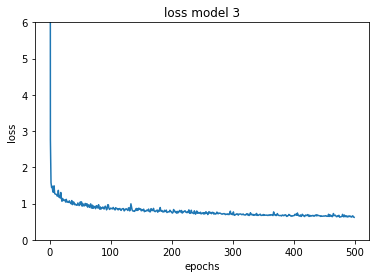

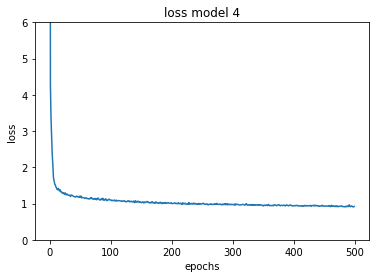

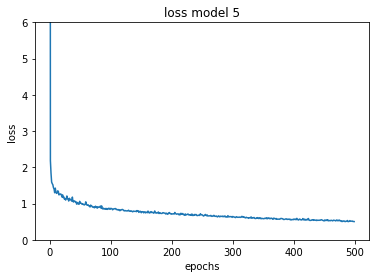

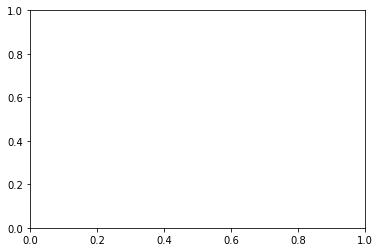

In [ ]:
i = 0
y_total = []
mee_models = []
for hp in hyperparameters:
    i += 1
    model = create_model(hp)
    history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=0)
    plt.plot(history.history['loss'])
    plt.ylim([0,6])
    plt.title('loss model '+ str(i))
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    plt.cla()
    y_pred = model.predict(X_test)
    res = mee(y_test, y_pred)
    y_total.append(y_pred)

y_mean = []
for i in range(len(y_total[0])):
    temp = 0
    for x in y_total:
        temp += x[i]
    y_mean.append(temp / len(y_total))

y_mean = np.array(y_mean)
error = mee(y_test, y_mean)



In [ ]:
for i in range(len(mee_models)):
    print(mee_models[i])

print('ensemble error: ', error)


ensemble error:  1.1754376685932357


Text(0.5, 1.0, 'ensemble model prediction vs target values')

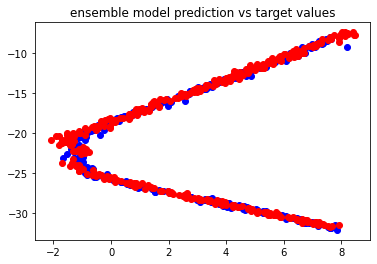

In [ ]:
#scatter plot comparing target values distribution and predicted values distribution
plt.scatter(y_mean[:,0], y_mean[:,1], color='blue')
plt.scatter(y_test[:,0], y_test[:,1], color='red')
plt.title('ensemble model prediction vs target values')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>